In [56]:
import numpy as np
from numpy import genfromtxt
import csv
import os

import pysindy as ps

import deepSI
from deepSI import System_data

import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [2]:
DATA_PATH = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data\upsampled\\"

FACTOR = [str(2), str(4), str(5), str(8), str(10)]
factor = [int(i) for i in FACTOR]
METHOD = ["akima", "makima", "linear"]
CSV = ".csv"

fs = 610.35
dt = 1/fs

DATA = []

for m in METHOD:
    for f in FACTOR:  
      PATH = os.path.join(DATA_PATH, m+"_"+f+"dt_silver"+CSV)
      data = genfromtxt(PATH, delimiter=",")
      DATA.append(data)

In [3]:
def NRMS(y_pred, y_true):
    RMS = np.sqrt(np.mean((y_pred-y_true)**2))
    return RMS/np.std(y_true)

In [103]:
pred_data = []
simo_data = []
pred_NRMS = []

for idx, d in enumerate(DATA):
    silver_data = System_data(u=d[:,0],y=d[:,1])
    train, test = silver_data.train_test_split(split_fraction=0.05)

    dt_i = dt/factor[idx % 5]
    
    differentiation_method = ps.FiniteDifference(order=3)

    feature_library = ps.ConcatLibrary([ps.PolynomialLibrary(degree=3)]) #ps.IdentityLibrary(),

    # stlsq_optimizer = ps.STLSQ()
    lasso_optimizer = Lasso(alpha=0.01, max_iter=5000, fit_intercept=False)

    model = ps.SINDy(feature_library=feature_library,
                 optimizer=lasso_optimizer,
                 discrete_time=True
                 )
    
    model.fit(train.y, u=train.u, t=dt_i)
    # model.print()
    # model.coefficients()

    x_predicted = model.predict(test.y, u=test.u)

    # t_test = np.linspace(0,dt_i*test.y.shape[0],test.y.shape[0])
    # x_simulated = model.simulate(test.y, u=test.u, t=test.u.shape[0])

    pred_data.append(x_predicted)
    # simo_data.append(x_simulated)
    pred_NRMS.append(NRMS(x_predicted.flatten(), test.y.flatten()))


In [105]:
def linear_map(y):
  return (y-np.min(y))/(np.max(y)-np.min(y))

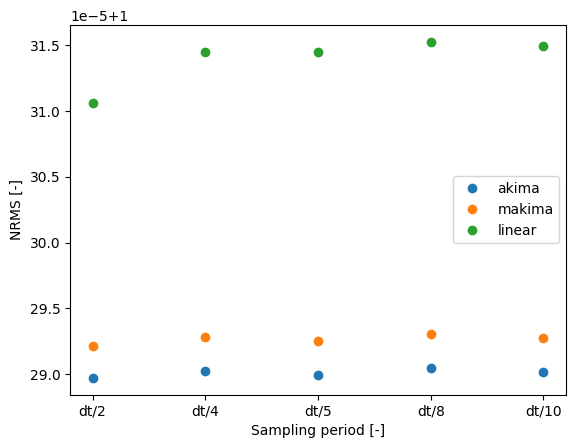

In [95]:
plt.plot(pred_NRMS[0:5],"o")
plt.plot(pred_NRMS[5:10],"o")
plt.plot(pred_NRMS[10:],"o")

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks([0, 1, 2, 3, 4], ['dt/2', 'dt/4', 'dt/5', 'dt/8', 'dt/10'])
plt.ylabel("NRMS [-]")
plt.xlabel("Sampling period [-]")
plt.legend(["akima","makima", "linear"])
plt.show()